# Enhanced Network Traffic Classification with:
- **SMOTE** (Synthetic Minority Over-sampling Technique) to balance classes
- **Focal Loss** to address class imbalance during training
- Uses pre-trained weights (`cnn_model_weights.pth`) when running an existing model

- **Advanced Models** using ResNet18 and MobileNetV2 for grayscale images
- **Enhanced Metrics** with precision-recall curves and per-class ROC curves


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from pyts.image import GramianAngularField
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Parameters
input_folder = './data'
output_folder = './output/smote/gaf_images/'
n_components = 30  # PCA reduced dimensions
gaf_size = 32       # GAF image size

# Initialize transformers
scaler = MinMaxScaler()
pca = PCA(n_components=n_components)
gaf = GramianAngularField(method='summation', image_size=gaf_size)

# Create output directory
os.makedirs(output_folder, exist_ok=True)


In [ ]:
# Process each CSV file
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]


for csv_file in csv_files:
    print(f"\n📄 Processing {csv_file}...")
    df_path = os.path.join(input_folder, csv_file)
    df = pd.read_csv(df_path)
    df.columns = df.columns.str.strip()

    if 'Label' not in df.columns:
        print(f"⚠️ Skipping {csv_file} — 'Label' column not found.")
        continue

    
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    labels = df['Label'].values
    features = df.select_dtypes(include=[np.number])

    # Remove inf or very large values
    features = features.replace([np.inf, -np.inf], np.nan).dropna()

    # --- SMOTE and Undersampling ---
    X = features.values
    y = labels
    unique_classes = np.unique(y)
    if len(unique_classes) > 1:
        print(f"Before SMOTE: {dict(zip(*np.unique(y, return_counts=True)))}")
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        print(f"After SMOTE: {dict(zip(*np.unique(y_res, return_counts=True)))}")
    else:
        print(f"Skipping SMOTE for {csv_file} — only found one class: {unique_classes[0]}")
        X_res, y_res = X, y
    # Optionally, apply undersampling after SMOTE
    # rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    # X_res, y_res = rus.fit_resample(X_res, y_res)
    # print(f"After undersampling: {dict(zip(*np.unique(y_res, return_counts=True)))}")

    # Continue with scaling and PCA

    # --- Merge Rare Classes ---
    # Define broader attack categories
    dos_attacks = ['DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris']
    brute_force_attacks = ['FTP-Patator', 'SSH-Patator']
    web_attacks = ['Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']
    
    # Function to map attacks to broader categories
    def map_to_broader_category(label):
        if label == 'BENIGN':
            return 'BENIGN'
        elif label == 'DDoS':
            return 'DDoS'
        elif label == 'PortScan':
            return 'PortScan'
        elif label in dos_attacks:
            return 'DoS'
        elif label in brute_force_attacks:
            return 'BruteForce'
        elif label in web_attacks:
            return 'WebAttack'
        elif label == 'Bot':
            return 'Bot'
        elif label == 'Infiltration':
            return 'Infiltration'
        elif label == 'Heartbleed':
            return 'Heartbleed'
        else:
            return 'Other'
    
    # Apply category mapping
    y_categorized = np.array([map_to_broader_category(label) for label in y_res])
    print(f"After category merging: {dict(zip(*np.unique(y_categorized, return_counts=True)))}")
    
    # Use the merged categories for further processing
    y_res = y_categorized
    features_scaled = scaler.fit_transform(X_res)
    features_reduced = pca.fit_transform(features_scaled)
    labels_res = y_res

    # Prepare output folders
    day_name = os.path.splitext(csv_file)[0]
    day_folder = os.path.join(output_folder, 'by_day', day_name)
    attack_folder = os.path.join(output_folder, 'by_attack_type')
    os.makedirs(day_folder, exist_ok=True)
    os.makedirs(attack_folder, exist_ok=True)

    print(f"Generating GAF images for up to all flows...")

    for idx, (flow, label) in enumerate(zip(features_reduced, labels_res)):
        try:
            flow_2d = flow.reshape(1, -1)
            gaf.image_size = min(gaf.image_size, flow_2d.shape[1])
            gaf_image = gaf.fit_transform(flow_2d)[0]


            # Save by day
            day_label_folder = os.path.join(day_folder, str(label))
            os.makedirs(day_label_folder, exist_ok=True)
            gaf_day_path = os.path.join(day_label_folder, f"flow_{idx}.png")
            plt.imsave(gaf_day_path, gaf_image, cmap='gray')

            # Save by attack type
            attack_label_folder = os.path.join(attack_folder, str(label))
            os.makedirs(attack_label_folder, exist_ok=True)
            gaf_attack_path = os.path.join(attack_label_folder, f"{day_name}_flow_{idx}.png")
            plt.imsave(gaf_attack_path, gaf_image, cmap='gray')

        except Exception as e:
            print(f"⚠️ Error on flow {idx}: {e}")
            continue

print("\n✅ GAF image generation complete.")


📄 Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Before SMOTE: {'BENIGN': 288359, 'Infiltration': 36}
After SMOTE: {'BENIGN': 288359, 'Infiltration': 288359}
After category merging: {'BENIGN': 288359, 'Infiltration': 288359}
Generating GAF images for up to all flows...

📄 Processing Monday-WorkingHours.pcap_ISCX.csv...
Skipping SMOTE for Monday-WorkingHours.pcap_ISCX.csv — only found one class: BENIGN
After category merging: {'BENIGN': 529481}
Generating GAF images for up to all flows...

📄 Processing Friday-WorkingHours-Morning.pcap_ISCX.csv...
Before SMOTE: {'BENIGN': 188955, 'Bot': 1956}
After SMOTE: {'BENIGN': 188955, 'Bot': 188955}
After category merging: {'BENIGN': 188955, 'Bot': 188955}
Generating GAF images for up to all flows...

📄 Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Before SMOTE: {'BENIGN': 127292, 'PortScan': 158804}
After SMOTE: {'BENIGN': 158804, 'PortScan': 158804}
After category merging: {'BENIGN': 158804, 'PortS

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob

class GAFDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(image_dir, '*', '*.png'))
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(image_dir)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_name = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_name]

        image = Image.open(image_path).convert('L')  # grayscale
        if self.transform:
            image = self.transform(image)

        return image, label

# Transform and DataLoader
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = GAFDataset(image_dir=os.path.join(output_folder, 'by_attack_type'), transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [9]:
# GPU/CUDA/MPS Support
import torch

# Check available devices
cuda_available = torch.cuda.is_available()
mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()

print(f"CUDA available: {cuda_available}")
print(f"MPS available: {mps_available}")

# Determine the best device to use
if cuda_available:
    device = torch.device("cuda")
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Using GPU (CUDA): {device_name}")
    
    # Show memory stats
    print("\nGPU Memory Stats:")
    print(f"Total memory: {torch.cuda.get_device_properties(current_device).total_memory / 1e9:.2f} GB")
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    
    # Optional: Set device settings for faster training
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
elif mps_available:
    device = torch.device("mps")
    print(f"Using GPU (Apple MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU for training (no GPU acceleration available)")

# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")

CUDA available: False
MPS available: True
Using GPU (Apple MPS)
PyTorch version: 2.5.1


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 15, 15]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 6, 6]
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(dataset.label_map)
model = SimpleCNN(num_classes)


In [11]:
# Advanced Model Implementations
import torchvision.models as models

# Function to modify ResNet18 for grayscale input
def get_resnet18_grayscale(num_classes):
    # Load pretrained ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1')
    
    # Modify first conv layer for grayscale (1 channel) input
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Modify final fully connected layer for our number of classes
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    
    return model

# Function to modify MobileNetV2 for grayscale input
def get_mobilenet_grayscale(num_classes):
    # Load pretrained MobileNetV2
    model = models.mobilenet_v2(weights='IMAGENET1K_V1')
    
    # Modify first conv layer for grayscale input
    model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    
    # Modify classifier for our number of classes
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    
    return model


In [12]:
# Model Selection
model_type = "resnet18"  # Options: "cnn", "resnet18", "mobilenet"

# Get the appropriate model
if model_type == "cnn":
    model = SimpleCNN(num_classes)
elif model_type == "resnet18":
    model = get_resnet18_grayscale(num_classes)
elif model_type == "mobilenet":
    model = get_mobilenet_grayscale(num_classes)
else:
    raise ValueError(f"Unknown model type: {model_type}")

# Print model architecture and parameter count
print(f"Using {model_type} model")
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Check if pretrained weights exist and load them if specified
weight_path = f'cnn_model_weights.pth'
if os.path.exists(weight_path) and model_type == "cnn":
    print(f"Loading pretrained weights from {weight_path}")
    model.load_state_dict(torch.load(weight_path))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/anmol/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.7MB/s]

Using resnet18 model
Total parameters: 11,174,857


In [ ]:
# Load pre-trained model weights (uncomment when using pre-trained model)
# model.load_state_dict(torch.load('cnn_model_weights.pth', map_location=device))
# model.eval()  # Set model to evaluation mode


In [14]:
import torch.optim as optim

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()


print(f"Using device: {device}")
model = model.to(device)
criterion = FocalLoss(gamma=2)  # Using gamma=2 as default
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0
    correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc*100:.2f}%")

print("✅ Training complete.")


Using device: mps
Epoch 1, Loss: 1211.3541, Accuracy: 98.64%
Epoch 2, Loss: 539.4677, Accuracy: 99.29%
Epoch 3, Loss: 428.6903, Accuracy: 99.44%
Epoch 4, Loss: 342.3024, Accuracy: 99.56%
Epoch 5, Loss: 294.1784, Accuracy: 99.64%
✅ Training complete.


In [15]:
# save model
torch.save(model.state_dict(), "resnet_model_weights.pth")


In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np

# Set model to evaluation mode
model.eval()

# Lists to collect predictions and true labels
all_preds = []
all_labels = []

# No gradient calculation needed during testing
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Get sorted label indices and names from dataset.label_map
label_map = dataset.label_map
label_indices = sorted(label_map.values())
label_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

# Classification report and confusion matrix
print("\n📊 Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=label_indices,
    target_names=label_names,
    zero_division=0  # avoids division by zero for missing classes
))




✅ Test Accuracy: 99.61%

📊 Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99    466032
         Bot       0.98      0.99      0.99     38103
  BruteForce       1.00      0.99      1.00    172567
        DDoS       1.00      1.00      1.00     25389
         DoS       1.00      1.00      1.00    352254
  Heartbleed       1.00      1.00      1.00     87779
Infiltration       1.00      1.00      1.00     57644
    PortScan       1.00      1.00      1.00     31784
   WebAttack       1.00      1.00      1.00    101150

    accuracy                           1.00   1332702
   macro avg       1.00      1.00      1.00   1332702
weighted avg       1.00      1.00      1.00   1332702



Generating advanced metrics...


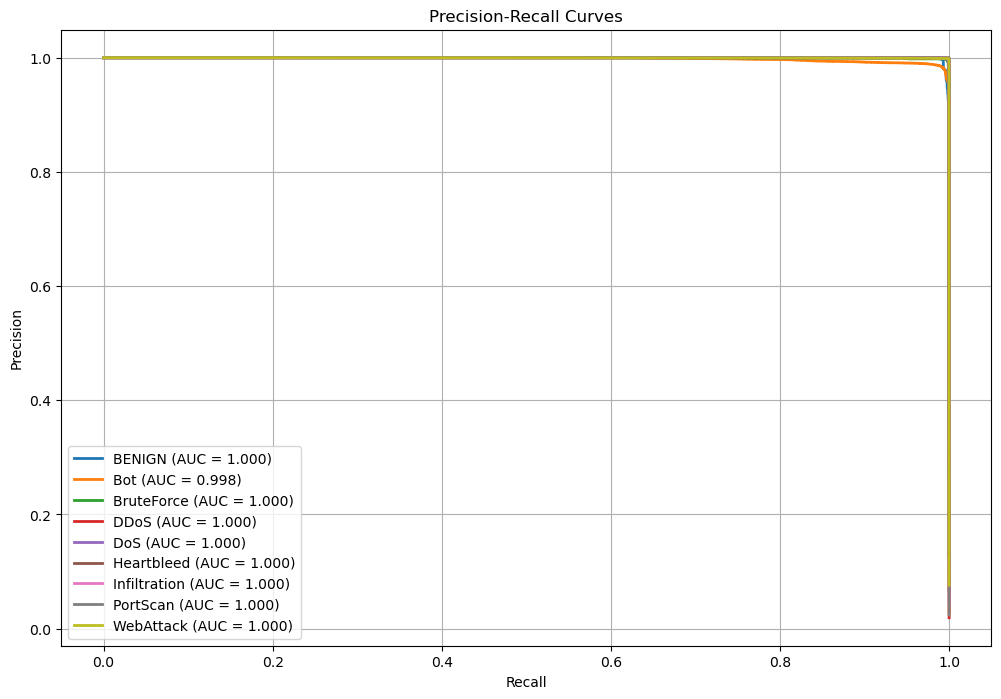

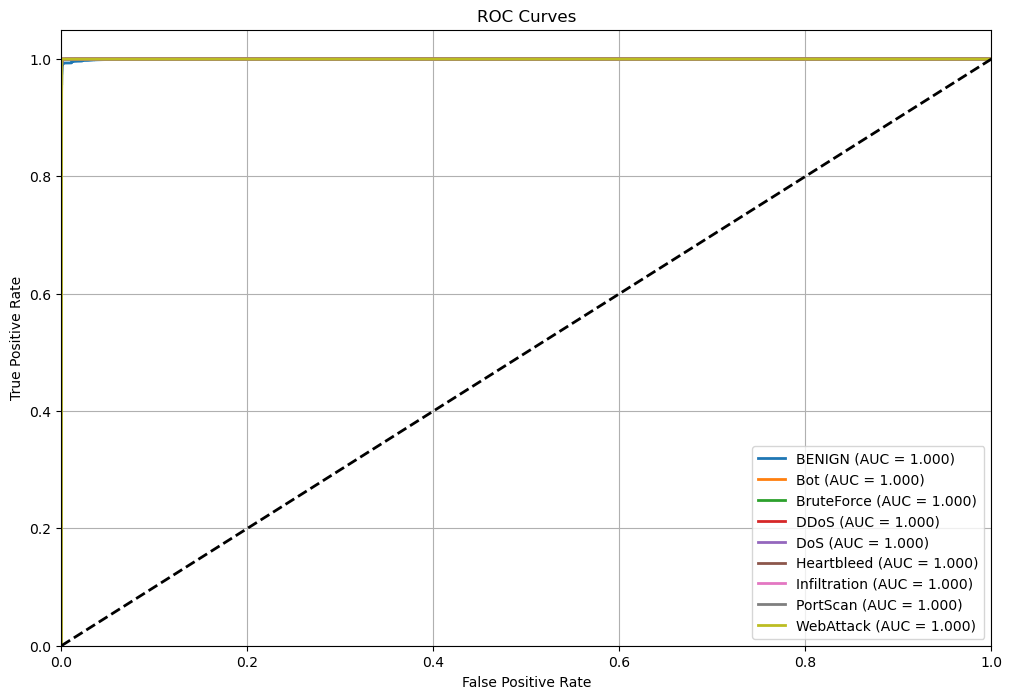

In [18]:
# Advanced metrics visualization
def plot_precision_recall_curves(y_true, y_pred_proba, classes):
    '''Plot precision-recall curve for each class'''
    plt.figure(figsize=(12, 8))
    
    # For each class
    for i, cls in enumerate(classes):
        # Binarize the output
        y_true_bin = (y_true == i).astype(int)
        
        # Get prediction probability for this class
        y_pred_proba_cls = y_pred_proba[:, i]
        
        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(y_true_bin, y_pred_proba_cls)
        
        # Calculate area under PR curve
        pr_auc = auc(recall, precision)
        
        # Plot PR curve
        plt.plot(recall, precision, lw=2, label=f'{cls} (AUC = {pr_auc:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('precision_recall_curves.png')
    plt.show()

def plot_roc_curves(y_true, y_pred_proba, classes):
    '''Plot ROC curve for each class'''
    plt.figure(figsize=(12, 8))
    
    # For each class
    for i, cls in enumerate(classes):
        # Binarize the output
        y_true_bin = (y_true == i).astype(int)
        
        # Get prediction probability for this class
        y_pred_proba_cls = y_pred_proba[:, i]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true_bin, y_pred_proba_cls)
        
        # Calculate area under ROC curve
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('roc_curves.png')
    plt.show()

# After model evaluation, add these lines:
print("Generating advanced metrics...")
# Get class probabilities on test data
model.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        test_probs.append(probs.cpu().numpy())
        test_labels.append(labels.numpy())

# Concatenate batches
test_probs = np.concatenate(test_probs)
test_labels = np.concatenate(test_labels)

# Plot precision-recall and ROC curves
class_names = list(dataset.label_map.keys())
plot_precision_recall_curves(test_labels, test_probs, class_names)
plot_roc_curves(test_labels, test_probs, class_names)

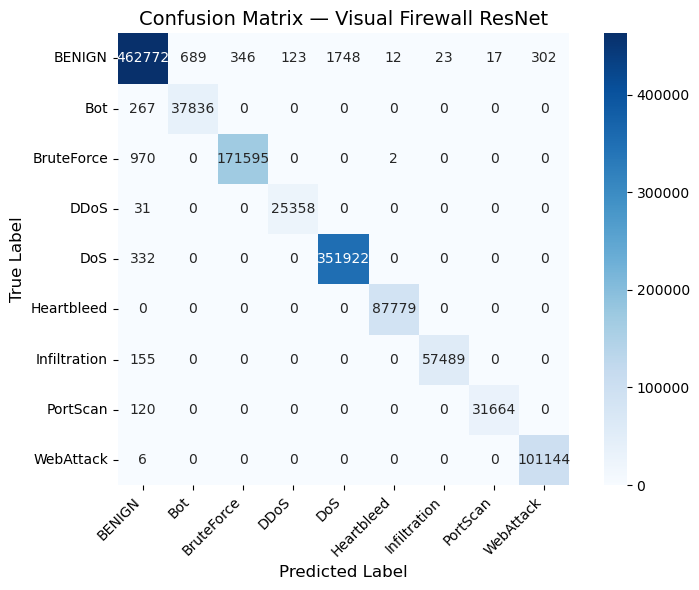

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_indices)

# Set larger figure size based on number of classes
fig_width = max(8, len(label_names) * 0.6)
fig_height = max(6, len(label_names) * 0.5)

plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    cbar=True,
    square=True
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix — Visual Firewall ResNet", fontsize=14)

# Rotate x-axis labels for better spacing
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ensure nothing is cut off
plt.tight_layout()

# Optional: Save as image
# plt.savefig("confusion_matrix.png", dpi=300)

plt.show()
